# Memory usage

The [first benchmark](http://www.xavierdupre.fr/app/_benchmarks/helpsphinx/sklbench_results/index.html) based on [scikti-learn's benchmark](https://github.com/jeremiedbb/scikit-learn_benchmarks) shows high peaks of memory usage for the python runtime on linear models. Let's see how to measure that.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Artificial huge data 

In [2]:
import numpy
N, nfeat = 300000, 200
N * nfeat * 8 / 1e9

0.48

In [3]:
X = numpy.random.random((N, nfeat))
y = numpy.empty((N, 50))
for i in range(y.shape[1]):
    y[:, i] = X.sum(axis=1) + numpy.random.random(N)
X.shape, y.shape

((300000, 200), (300000, 50))

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1)

In [5]:
from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [6]:
from mlprodict.onnx_conv import to_onnx
from mlprodict.onnxrt import OnnxInference
clr_onnx = to_onnx(clr, X_train[:1])
oinfpy = OnnxInference(clr_onnx, runtime='python')

Let's minimize the cost of verifications on scikit-learn's side.

In [7]:
from sklearn import set_config
set_config(assume_finite=True)

## Profiling the prediction function

In [8]:
from pyquickhelper.pycode.profiling import profile
print(profile(lambda: clr.predict(X_test), 
              pyinst_format='text')[1])


  _     ._   __/__   _ _  _  _ _/_   Recorded: 17:32:16  Samples:  3
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.305     CPU time: 0.594
/   _/                      v3.0.1

Program: c:\python372_x64\lib\site-packages\ipykernel_launcher.py -f C:\Users\xavie\AppData\Roaming\jupyter\runtime\kernel-5c4ae00c-a016-41c8-b772-549a92da3b1f.json

0.306 profile  pyquickhelper\pycode\profiling.py:49
|- 0.295 <lambda>  <ipython-input-8-1097e70fe6c7>:2
|  `- 0.295 predict  sklearn\linear_model\_base.py:222
|     `- 0.295 _decision_function  sklearn\linear_model\_base.py:215
|        |- 0.201 safe_sparse_dot  sklearn\utils\extmath.py:118
|        `- 0.094 [self]  
`- 0.011 [self]  




In [9]:
import numpy

def nastype32(mat):
    return mat.astype(numpy.float32)

print(profile(lambda: oinfpy.run({'X': nastype32(X_test)}), 
              pyinst_format='text')[1])


  _     ._   __/__   _ _  _  _ _/_   Recorded: 17:32:17  Samples:  5
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.276     CPU time: 0.438
/   _/                      v3.0.1

Program: c:\python372_x64\lib\site-packages\ipykernel_launcher.py -f C:\Users\xavie\AppData\Roaming\jupyter\runtime\kernel-5c4ae00c-a016-41c8-b772-549a92da3b1f.json

0.277 profile  pyquickhelper\pycode\profiling.py:49
|- 0.272 <lambda>  <ipython-input-9-da4aa05db7ed>:6
|  |- 0.157 nastype32  <ipython-input-9-da4aa05db7ed>:3
|  |- 0.096 run  mlprodict\onnxrt\onnx_inference.py:411
|  |  `- 0.096 _run_sequence_runtime  mlprodict\onnxrt\onnx_inference.py:490
|  |     `- 0.096 run  mlprodict\onnxrt\onnx_inference_node.py:136
|  |        `- 0.096 run  mlprodict\onnxrt\ops_cpu\_op.py:365
|  |           `- 0.096 run  mlprodict\onnxrt\ops_cpu\_op.py:285
|  |              `- 0.096 _run  mlprodict\onnxrt\ops_cpu\op_linear_regressor.py:27
|  |                 |- 0.083 numpy_dot_inplace  mlprodict\onnxrt\ops_cpu\_op_numpy_

Most of the time is taken out into casting into float. Let's take it out.

In [10]:
X_test32 = X_test.astype(numpy.float32)

print(profile(lambda: oinfpy.run({'X': X_test32}), 
              pyinst_format='text')[1])


  _     ._   __/__   _ _  _  _ _/_   Recorded: 17:32:17  Samples:  3
 /_//_/// /_\ / //_// / //_'/ //     Duration: 0.111     CPU time: 0.203
/   _/                      v3.0.1

Program: c:\python372_x64\lib\site-packages\ipykernel_launcher.py -f C:\Users\xavie\AppData\Roaming\jupyter\runtime\kernel-5c4ae00c-a016-41c8-b772-549a92da3b1f.json

0.110 profile  pyquickhelper\pycode\profiling.py:49
|- 0.105 <lambda>  <ipython-input-10-fe055596e921>:3
|  `- 0.105 run  mlprodict\onnxrt\onnx_inference.py:411
|     `- 0.105 _run_sequence_runtime  mlprodict\onnxrt\onnx_inference.py:490
|        `- 0.105 run  mlprodict\onnxrt\onnx_inference_node.py:136
|           `- 0.105 run  mlprodict\onnxrt\ops_cpu\_op.py:365
|              `- 0.105 run  mlprodict\onnxrt\ops_cpu\_op.py:285
|                 `- 0.105 _run  mlprodict\onnxrt\ops_cpu\op_linear_regressor.py:27
|                    |- 0.094 numpy_dot_inplace  mlprodict\onnxrt\ops_cpu\_op_numpy_helper.py:8
|                    |  `- 0.094 dot  <__ar

Much better.

## SGDClasifier

This models is implemented with many ONNX nodes. Let's how it behaves.

In [11]:
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import load_iris
data = load_iris()
Xir, yir = data.data, data.target
Xir_train, Xir_test, yir_train, yir_test = train_test_split(Xir, yir)
sgcl = SGDClassifier()
sgcl.fit(Xir_train, yir_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
sgd_onnx = to_onnx(sgcl, Xir_train.astype(numpy.float32))

In [13]:
%load_ext mlprodict

In [14]:
%onnxview sgd_onnx

In [15]:
sgd_oinf = OnnxInference(sgd_onnx)

In [16]:
def call_n_times_x1(n, X_test, sgd_oinf):
    for i in range(n):
        res = sgd_oinf.run({'X': X_test})
    return res

call_n_times_x1(20, Xir_test[:1].astype(numpy.float32), sgd_oinf)

{'output_label': array([1], dtype=int64),
 'output_probability': [{0: -105.19381, 1: -26.43415, 2: -174.7298}]}

In [17]:
sgcl.decision_function(Xir_test[:1])

array([[-105.19379786,  -26.43412984, -174.72978497]])

In [18]:
xir_32 = Xir_test[:1].astype(numpy.float32)

print(profile(lambda: call_n_times_x1(20000, xir_32, sgd_oinf), 
              pyinst_format='text')[1])


  _     ._   __/__   _ _  _  _ _/_   Recorded: 17:32:19  Samples:  1800
 /_//_/// /_\ / //_// / //_'/ //     Duration: 2.908     CPU time: 2.469
/   _/                      v3.0.1

Program: c:\python372_x64\lib\site-packages\ipykernel_launcher.py -f C:\Users\xavie\AppData\Roaming\jupyter\runtime\kernel-5c4ae00c-a016-41c8-b772-549a92da3b1f.json

2.907 profile  pyquickhelper\pycode\profiling.py:49
`- 2.907 <lambda>  <ipython-input-18-ec5a6181dc40>:3
   `- 2.907 call_n_times_x1  <ipython-input-16-32f502ef162e>:1
      |- 2.860 run  mlprodict\onnxrt\onnx_inference.py:411
      |  |- 2.793 _run_sequence_runtime  mlprodict\onnxrt\onnx_inference.py:490
      |  |  |- 2.547 run  mlprodict\onnxrt\onnx_inference_node.py:136
      |  |  |  |- 0.850 [self]  
      |  |  |  |- 0.668 run  mlprodict\onnxrt\ops_cpu\_op.py:130
      |  |  |  |  |- 0.415 _run  mlprodict\onnxrt\ops_cpu\op_array_feature_extractor.py:59
      |  |  |  |  |  |- 0.358 _array_feature_extrator  mlprodict\onnxrt\ops_cpu\op_arr

The code in ``mlprodict/onnxrt/onnx_inference_node.py`` just calls an operator and updates the list containing all the results. The time in here is significant if the number of node is huge if the python runtime is used.

## Memory profiling

In [19]:
%matplotlib inline

In [20]:
from memory_profiler import memory_usage
memprof_skl = memory_usage((clr.predict, (X_test, )), timestamps=True, interval=0.01)

In [21]:
memprof_skl

[(1522.69921875, 1588779143.7355406),
 (1522.50390625, 1588779154.4229498),
 (1509.82421875, 1588779154.4339223),
 (1495.03515625, 1588779154.444888),
 (1479.4453125, 1588779154.4558592),
 (1464.78515625, 1588779154.4668288),
 (1452.02734375, 1588779154.4777994),
 (1441.28515625, 1588779154.4887717),
 (1427.66015625, 1588779154.4997416),
 (1414.4609375, 1588779154.5107129),
 (1396.76171875, 1588779154.521683),
 (1381.37109375, 1588779154.532653),
 (1377.53515625, 1588779154.5496078),
 (1374.83203125, 1588779154.5695539),
 (1364.3984375, 1588779154.5805242),
 (1349.95703125, 1588779154.5914948),
 (1334.51953125, 1588779154.602466),
 (1319.44921875, 1588779154.6164305),
 (1307.64453125, 1588779154.6283967),
 (1293.1640625, 1588779154.6393676),
 (1277.515625, 1588779154.650338),
 (1262.125, 1588779154.661309),
 (1248.11328125, 1588779154.6722806),
 (1231.4765625, 1588779154.6832507),
 (1218.5625, 1588779154.69422),
 (1199.4453125, 1588779154.7051919),
 (1181.4140625, 1588779154.716162),
 

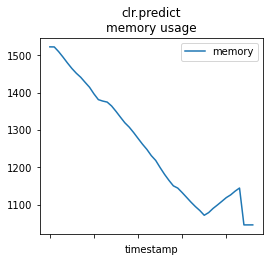

In [22]:
import matplotlib.pyplot as plt
from pandas import DataFrame, to_datetime

def mem_profile_plot(mem, title):
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    df = DataFrame(mem, columns=["memory", "timestamp"])
    df["timestamp"] = to_datetime(df.timestamp)
    df["timestamp"] -= df.timestamp.min()
    df.set_index("timestamp").plot(ax=ax)
    ax.set_title(title + "\nmemory usage")
    return ax

mem_profile_plot(memprof_skl, "clr.predict");

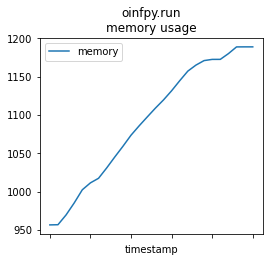

In [23]:
memprof_onx = memory_usage((oinfpy.run, ({'X': X_test32}, )), timestamps=True, interval=0.01)
mem_profile_plot(memprof_onx, "oinfpy.run");

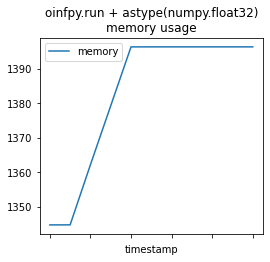

In [24]:
memprof_onx2 = memory_usage((oinfpy.run, ({'X': X_test.astype(numpy.float32, copy=False)}, )),
                           timestamps=True, interval=0.01)
mem_profile_plot(memprof_onx2, "oinfpy.run + astype(numpy.float32)");

This is not very informative.

## Memory profiling outside the notebook

More precise.

In [25]:
%%writefile mprof_clr_predict.py

import numpy
N, nfeat = 300000, 200
X = numpy.random.random((N, nfeat))
y = numpy.empty((N, 50))
for i in range(y.shape[1]):
    y[:, i] = X.sum(axis=1) + numpy.random.random(N)
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1)   

from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X_train, y_train)

from sklearn import set_config
set_config(assume_finite=True)    

from memory_profiler import profile
@profile
def clr_predict():
    clr.predict(X_test)
    
clr_predict()

Overwriting mprof_clr_predict.py


In [26]:
!python -m memory_profiler mprof_clr_predict.py --timestamp

Filename: mprof_clr_predict.py

Line #    Mem usage    Increment   Line Contents


The notebook seems to increase the memory usage.

In [27]:
%%writefile mprof_onnx_run.py

import numpy
N, nfeat = 300000, 200
X = numpy.random.random((N, nfeat))
y = numpy.empty((N, 50))
for i in range(y.shape[1]):
    y[:, i] = X.sum(axis=1) + numpy.random.random(N)
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1)   

from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X_train, y_train)

from mlprodict.onnx_conv import to_onnx
from mlprodict.onnxrt import OnnxInference
clr_onnx = to_onnx(clr, X_train[:1])
oinfpy = OnnxInference(clr_onnx, runtime='python')
X_test32 = X_test.astype(numpy.float32)

from sklearn import set_config
set_config(assume_finite=True)    

from memory_profiler import profile
@profile
def oinfpy_predict():
    oinfpy.run({'X': X_test32})
    
oinfpy_predict()

    20   1148.4 MiB   1148.4 MiB   @profile
Overwriting mprof_onnx_run.py    21                             def clr_predict():
    22   1140.4 MiB      0.0 MiB       clr.predict(X_test)





In [28]:
!python -m memory_profiler mprof_onnx_run.py --timestamp

Filename: mprof_onnx_run.py

Line #    Mem usage    Increment   Line Contents
    26   1504.5 MiB   1504.5 MiB   @profile
    27                             def oinfpy_predict():
    28   1505.8 MiB      1.3 MiB       oinfpy.run({'X': X_test32})




In [29]:
%%writefile mprof_onnx_run32.py

import numpy
N, nfeat = 300000, 200
X = numpy.random.random((N, nfeat))
y = numpy.empty((N, 50))
for i in range(y.shape[1]):
    y[:, i] = X.sum(axis=1) + numpy.random.random(N)
    
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1)   

from sklearn.linear_model import LinearRegression
clr = LinearRegression()
clr.fit(X_train, y_train)

from mlprodict.onnx_conv import to_onnx
from mlprodict.onnxrt import OnnxInference
clr_onnx = to_onnx(clr, X_train[:1])
oinfpy = OnnxInference(clr_onnx, runtime='python')

from sklearn import set_config
set_config(assume_finite=True)    

from memory_profiler import profile
@profile
def oinfpy_predict32():
    oinfpy.run({'X': X_test.astype(numpy.float32)})
    
oinfpy_predict32()

Overwriting mprof_onnx_run32.py


In [30]:
!python -m memory_profiler mprof_onnx_run32.py --timestamp

Filename: mprof_onnx_run32.py

Line #    Mem usage    Increment   Line Contents
    25   1298.2 MiB   1298.2 MiB   @profile
    26                             def oinfpy_predict32():
    27   1299.5 MiB      1.3 MiB       oinfpy.run({'X': X_test.astype(numpy.float32)})


